<a href="https://colab.research.google.com/github/KartikayBhardwaj-dev/Ai_lab/blob/main/ai_lab_week08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All about AI agents with langGraph

#Install required packages

In [1]:
%pip install -q langgraph langchain_groq pydot networks

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 3.3 MB/s eta 0:00:00


#import and api key

In [2]:
import os
from getpass import getpass
from typing import List, Dict, Any, Optional, TypedDict
from google.colab import userdata

#langgrapgh and model
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage

#visualization and utility
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
#setting groq api
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

#initiate llm
llm = ChatGroq(model="openai/gpt-oss-20b", temperature=0)

In [4]:
llm.invoke("classify the following email as 'spam' or 'not-spam', email = we have a meeting tom at sharp 11:00 a.m").content

'not-spam'

#Workflow of agent
1. Read email
2. detetcts whether they are spam or not  
   - if spam , skip everything
3. if not spam, classifies urgency
   - Very urgent, Urgent, Normal
4. Summarize the content
5. Draft the reply acc
6. Review them
7. send them reply email

#initiate class

In [5]:
class EmailState(TypedDict):
  emails: List[str]
  spam_flags: List[bool]
  categories: List[str]
  summaries: List[str]
  replies: List[str]
  reviewed_replies: List[str]


#Define nodes:


for reading emails

In [6]:
def read_emails(state: EmailState):
  print("Reading emails📖")
  return {"emails": state.get("emails", [])}

for filtering email

In [29]:
def spam_filter_node(state: EmailState):
  print("checking for spam🚫")
  emails = state["emails"]
  classifications = []
  spam_flags = []

  for email in emails:
    prompt = f"""
    classify the following email as 'spam' or 'legitimate'
    Email Content:
    {email}
    """
    result = llm.invoke(prompt)
    classification = result.content.strip().lower()
    classifications.append(classification)
    spam_flags.append("Spam" if "spam" in classification else "legitimate") # Changed to boolean
  return {"classifications": classifications, "spam_flags": spam_flags}


For categorize of email

In [30]:
def categorize_emails(state: EmailState):
  print("categorizing Emails by Urgency.. 👍")
  emails = state["emails"]
  spam_flags = state["spam_flags"]
  categories = []
  for email, spam_flag in zip(emails, spam_flags):
    if spam_flag == "Spam": # Changed condition to boolean
      categories.append("Spam")
    elif "urgent" in email.lower() and "today" in email.lower():
      categories.append("Very Urgent")
    elif "deadline" in email.lower() or "tomorrow" in email.lower():
      categories.append("Urgent")
    else:
      categories.append("Normal")
  print(f"Classification: {spam_flags} & {categories}")
  return {"categories": categories}


for Summarize emails

In [33]:
def summarize_emails(state: EmailState):
  print("Summarizing Emails...😩")
  summaries = []
  for email, spam_flag in zip(state["emails"], state["spam_flags"]):
    if spam_flag == "Spam": # Changed condition to boolean
      summaries.append("Skipped (spam)")
    else:
      prompt = f"Summarize this email briefly: \n\n{email}"
      result = llm.invoke(prompt)
      summaries.append(result.content)
  return {"summaries": summaries}



for draft replies

In [34]:
def draft_replies(state: EmailState):
  print("Drafting Replies Bassed on email.. 📧" )
  replies = []
  for summary, category in zip(state["summaries"], state["categories"]): # Fixed comma
    if category == "Spam":
      replies.append("Skipped (spam)")
      continue
    urgency_tone = {
        "Very Urgent": "Respond immediately with confirmation and action plan",
        "Urgent": "Respond Promplty acknowlwdging the task",
        "Normal": "Respond politely confirming reciept and timeline"
    }
    prompt = f"Write a short reply for this email summary in tone: {urgency_tone[category]} \n\nSummary: {summary}"
    result = llm.invoke(prompt)
    replies.append(result.content)
  return {"replies": replies}


Review Replies

In [35]:
def review_replies(state: EmailState):
  print("Reviwing Replies..🦉")
  reviewed = []
  for reply, category in zip(state["replies"], state["categories"]):
    if category == "Spam":
      reviewed.append("Skipped (spam)")
    else:
      reviewed.append(reply)
  return {"reviewed_replies": reviewed}


Send emails

In [36]:
def send_emails(state: EmailState):
  print("Sending emails..")
  for reply, category in zip(state["reviewed_replies"], state["categories"]):
    if category != "Spam":
      print(f"\n({category}) -> {reply}")

  return {}

handle spam

In [37]:
def handle_spam(state: EmailState):
  print("Spam Detected skipping all processing for spam emails")
  return {}

#Create Graph using Node

In [38]:
graph = StateGraph(EmailState)
graph.add_node("read_emails", read_emails)
graph.add_node("spam_filter", spam_filter_node)
graph.add_node("categorize_emails", categorize_emails)
graph.add_node("summarize_emails", summarize_emails)
graph.add_node("draft_replies", draft_replies)
graph.add_node("review_replies", review_replies)
graph.add_node("send_emails", send_emails)
graph.add_node("handle_spam", handle_spam)

#start itr with first node of graph

In [39]:
graph.add_edge(START, "read_emails")
graph.add_edge("read_emails",  "spam_filter")


#create route for spam check
- after spam checking which node model pick to decide

In [40]:
def route_after_spam_check(state: EmailState):
  if all(flag ==  "Spam" for flag in state["spam_flags"]): # Check if all are True
    return "handle_spam"
  else:
    return "categorize_emails"


#adding the down condition for spam and categorise

In [41]:
graph.add_conditional_edges("spam_filter", route_after_spam_check,
                            {"handle_spam": "handle_spam",
                             "categorize_emails": "categorize_emails"})

#more flows


In [42]:
graph.add_edge("categorize_emails", "summarize_emails")
graph.add_edge("summarize_emails", "draft_replies")
graph.add_edge("draft_replies", "review_replies")
graph.add_edge("review_replies", "send_emails")


In [43]:
graph.add_edge("send_emails", END)
graph.add_edge("handle_spam", END)

#Graph

In [44]:
compiled_graph = graph.compile()

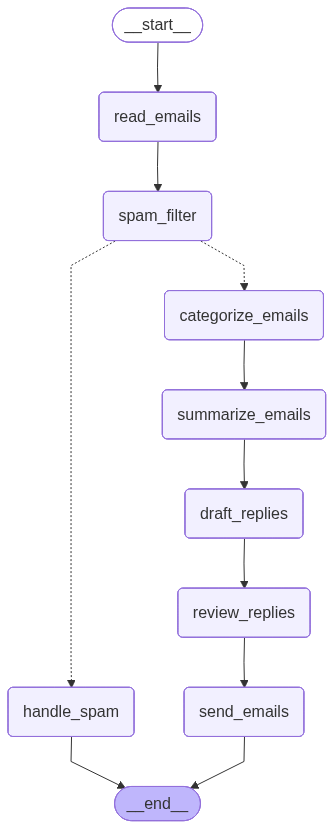

In [45]:
compiled_graph

#Sample Emails

In [46]:
sample_emails = [
    #"The final report must be submitted by 5 pm today",
    #"Congratulations! You just won a lottery",
    "Reminder: Team Meeting tomorrow at 10 AM"
]


In [47]:
initial_state = {"emails": sample_emails,}
final_state = compiled_graph.invoke(initial_state)

Reading emails📖
checking for spam🚫
categorizing Emails by Urgency.. 👍
Classification: ['legitimate'] & ['Urgent']
Summarizing Emails...😩
Drafting Replies Bassed on email.. 📧
Reviwing Replies..🦉
Sending emails..

(Urgent) -> Subject: Re: Team Meeting Tomorrow

Got it—I'll be there at 10 AM tomorrow. Thanks for the reminder.
